# Sprint10 深層学習スクラッチ ディープニューラルネットワーク

# 1.このSprintについて

## Sprintの目的
スクラッチを通してニューラルネットワークの発展的内容を理解する

## どのように学ぶか
スクラッチで作成したニューラルネットワークの実装を拡張していきます。

# 2.ディープニューラルネットワークスクラッチ
前回は3層のニューラルネットワークを作成しましたが、今回はこれを任意の層数に拡張しやすいものに書き換えていきます。その上で、活性化関数や初期値、最適化手法について発展的なものを扱えるようにしていきます。


このようなスクラッチを行うことで、今後各種フレームワークを利用していくにあたり、内部の動きが想像できることを目指します。


名前は新しくScratchDeepNeuralNetrowkClassifierクラスとしてください。

層などのクラス化
クラスにまとめて行くことで、構成を変更しやすい実装にしていきます。


#### 手を加える箇所


・層の数  
・層の種類（今後畳み込み層など他のタイプの層が登場する）  
・活性化関数の種類  
・重みやバイアスの初期化方法  
・最適化手法  

そのために、全結合層、各種活性化関数、重みやバイアスの初期化、最適化手法それぞれのクラスを作成します。


実装方法は自由ですが、簡単な例を紹介します。サンプルコード1のように全結合層と活性化関数のインスタンスを作成し、サンプルコード2,3のようにして使用します。それぞれのクラスについてはこのあと解説します。

#### 《サンプルコード1》

ScratchDeepNeuralNetrowkClassifierのfitメソッド内

```python
# self.sigma : ガウス分布の標準偏差
# self.lr : 学習率
# self.n_nodes1 : 1層目のノード数
# self.n_nodes2 : 2層目のノード数
# self.n_output : 出力層のノード数
optimizer = SGD(self.lr)
self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
self.activation1 = Tanh()
self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
self.activation2 = Tanh()
self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
self.activation3 = Softmax()
```

#### 《サンプルコード2》


イテレーションごとのフォワード

```python
A1 = self.FC1.forward(X)
Z1 = self.activation1.forward(A1)
A2 = self.FC2.forward(Z1)
Z2 = self.activation2.forward(A2)
A3 = self.FC3.forward(Z2)
Z3 = self.activation3.forward(A3)
```

#### 《サンプルコード3》


イテレーションごとのバックワード

```python
dA3 = self.activation3.backward(Z3, Y) # 交差エントロピー誤差とソフトマックスを合わせている
dZ2 = self.FC3.backward(dA3)
dA2 = self.activation2.backward(dZ2)
dZ1 = self.FC2.backward(dA2)
dA1 = self.activation1.backward(dZ1)
dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
```

## 【問題1】全結合層のクラス化

全結合層のクラス化を行なってください。


以下に雛形を載せました。コンストラクタで重みやバイアスの初期化をして、あとはフォワードとバックワードのメソッドを用意します。重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、煩雑な入出力は不要になります。


なお、インスタンスも引数として渡すことができます。そのため、初期化方法のインスタンスinitializerをコンストラクタで受け取れば、それにより初期化が行われます。渡すインスタンスを変えれば、初期化方法が変えられます。


また、引数として自身のインスタンスselfを渡すこともできます。これを利用してself.optimizer.update(self)という風に層の重みの更新が可能です。更新に必要な値は複数ありますが、全て全結合層が持つインスタンス変数にすることができます。


初期化方法と最適化手法のクラスについては後述します。


#### 《雛形》

In [97]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        self.network = {}
        self.network["W"] = initializer.W(n_nodes1, n_nodes2)
        self.network["B"] = initializer.B(n_nodes2)
        self.A = 0
        self.grad = {}
        self.X = 0

        pass
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        # 自層への入力
        A =  np.dot(X, self.network["W"] ) + self.network["B"]
        self.X = X

        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """

        # bの勾配
        self.grad["B"] = np.sum(dA, axis=0)

        # Wの勾配       
        self.grad["W"]= np.dot(self.X.T, dA)
    
        # 次層へのデルタ
        dZ = np.dot(dA, self.network["W"].T)
    
        # 更新
        self = self.optimizer.update(self)
        return dZ
    

## 【問題2】初期化方法のクラス化

初期化を行うコードをクラス化してください。


前述のように、全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにします。以下の雛形に必要なコードを書き加えていってください。標準偏差の値（sigma）はコンストラクタで受け取るようにすることで、全結合層のクラス内にこの値（sigma）を渡さなくてすむようになります。


これまで扱ってきた初期化方法はSimpleInitializerクラスと名付けることにします。


#### 《雛形》

In [4]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        #print("W.shape = ", W.shape)
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """

        B = np.zeros(n_nodes2)

        return B
    

## 【問題6】重みの初期値
ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきました。しかし、どのような値にすると良いかが知られています。シグモイド関数やハイパボリックタンジェント関数のときは Xavierの初期値 （またはGlorotの初期値）、ReLUのときは Heの初期値 が使われます。


XavierInitializerクラスと、HeInitializerクラスを作成してください。

Xavierの初期値
Xavierの初期値における標準偏差 $\sigma$ は次の式で求められます。

$$
\sigma = \frac{1}{\sqrt{n}}
$$
$n$ : 前の層のノード数


《論文》


Glorot, X., & Bengio, Y. (n.d.). Understanding the difficulty of training deep feedforward neural networks.

Heの初期値
Heの初期値における標準偏差 \sigma は次の式で求められます。

$$
\sigma = \sqrt{\frac{2}{n}}
$$
$n$ : 前の層のノード数


#### 《論文》


He, K., Zhang, X., Ren, S., & Sun, J. (2015). Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification.





In [192]:
class XavierInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        print("★★★XavierInitializer")
        self.sigma = sigma

    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        print("★★★XavierInitializer: W Set")
        self.n_nodes1 = n_nodes1
        self.W = np.random.rand(n_nodes1, n_nodes2) / np.sqrt(n_nodes1)     

        return self.W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        print("★★★XavierInitializer: B Set")
        self.B = np.random.randn(n_nodes2) 
        
        return self.B
    

In [193]:
class HeInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = np.random.rand(n_nodes1, n_nodes2) * np.sqrt(2 /n_nodes1)

        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = np.random.randn(n_nodes2)
        return B
    

## 【問題4】活性化関数のクラス化
活性化関数のクラス化を行なってください。


ソフトマックス関数のバックプロパゲーションには交差エントロピー誤差の計算も含む実装を行うことで計算が簡略化されます。

#### 発展的要素

活性化関数や重みの初期値、最適化手法に関してこれまで見てきた以外のものを実装していきます。

In [7]:
class Sigmoid:
    """
    活性化関数：sigmoid
    Parameters
    ----------
    A : 活性化関数への入力
    """
    def __init__(self):
        self.Z = 0
        pass
        
    def forward(self, A):
        self.Z = 1/(1 + np.exp(-A))
        return self.Z
    
    def backward(self, dZ):
        dx = dZ * (1.0 - self.Z) * self.Z
        return dx
    
    
    '''
    def d_sigmoid(self, x):
        dx = (1.0 - self.sigmoid(x)) * self.sigmoid(x)
        
        # 2層でのデルタ
        delta2 = np.dot(delta3, W3.T) * functions.d_sigmoid(z2)
        delta2 = np.dot(delta3, W3.T) * (1.0 - self.sigmoid(x)) * self.sigmoid(x)
    '''

In [8]:
class Tanh:
    """
    活性化関数：sigmoid
    Parameters
    ----------
    A : 活性化関数への入力
    """
    def __init__(self):
        self.A = 0
        
    def forward(self, A):
        self.A = A
        return np.tanh(A)
    
    def backward(self, dZ):
        dx = dZ * (1.0 - self.forward(self.A)**2)
        return dx

In [9]:
class Softmax:
    """
    活性化関数：softmax
    Parameters
    ----------
    A : 活性化関数への入力
    """
    def __init__(self):
        pass
        
    def forward(self, A):
        if A.ndim == 2:
            A = A.T
            A = A - np.max(A, axis=0)
            y = np.exp(A) / np.sum(np.exp(A), axis=0)
            return y.T

        A = A - np.max(A) # オーバーフロー対策
        return np.exp(A) / np.sum(np.exp(A))
    
    def backward(self, y, y_pred):
        batch_size = y.shape[0]   
        if y.size == y_pred.size: # 教師データがone-hot-vectorの場合
            dx = (y_pred - y) / batch_size
        else:
            dx = y.copy()
            dx[np.arange(batch_size), y] -= 1
            dx = dx / batch_size
            
        return dx


## 【問題5】ReLUクラスの作成

現在一般的に使われている活性化関数であるReLU（Rectified Linear Unit）をReLUクラスとして実装してください。


ReLUは以下の数式です。

$$
% <![CDATA[
f(x) = ReLU(x) = \begin{cases}
x  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases} %]]>
$$
$x$ : ある特徴量。スカラー


実装上はnp.maximumを使い配列に対してまとめて計算が可能です。


numpy.maximum — NumPy v1.15 Manual


一方、バックプロパゲーションのための $x$ に関する $f(x)$ の微分は以下のようになります。

$$
% <![CDATA[
\frac{\partial f(x)}{\partial x} = \begin{cases}
1  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases} %]]>
$$
数学的には微分可能ではないですが、 $x=0$ のとき $0$ とすることで対応しています。


フォワード時の $x$ の正負により、勾配を逆伝播するかどうかが決まるということになります。



In [106]:
class Relu:
    """
    活性化関数：relu
    Parameters
    ----------
    A : 活性化関数への入力
    """
    def __init__(self):
        self.A = 0
        
    def forward(self, A):
        self.A = A
        Z = np.maximum(0, A)
        return Z
    
    def backward(self, Z):
        dx = np.where(self.A > 0, Z, 0)
        return dx

## 【問題3】最適化手法のクラス化

最適化手法のクラス化を行なってください。


最適化手法に関しても初期化方法同様に全結合層にインスタンスとして渡します。バックワードのときにself.optimizer.update(self)のように更新できるようにします。以下の雛形に必要なコードを書き加えていってください。


これまで扱ってきた最適化手法はSGDクラス（Stochastic Gradient Descent、確率的勾配降下法）として作成します。


#### 雛形

```python
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
```

In [172]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        # SGD =====================================================
        for key in ('W','B'):
            layer.network[key] -= self.lr * layer.grad[key] 
        
        return layer

## 【問題7】最適化手法

学習率は学習過程で変化させていく方法が一般的です。基本的な手法である AdaGrad のクラスを作成してください。


まず、これまで使ってきたSGDを確認します。

$$
W_i^{\prime} = W_i - \alpha E(\frac{\partial L}{\partial W_i}) \\
B_i^{\prime} = B_i - \alpha E(\frac{\partial L}{\partial B_i})
$$
$\alpha$ : 学習率（層ごとに変えることも可能だが、基本的には全て同じとする）


$\frac{\partial L}{\partial W_i}$ : $W_i$ に関する損失 $L$ の勾配


$\frac{\partial L}{\partial B_i}$ : $B_i$ に関する損失 $L$ の勾配


$E()$ : ミニバッチ方向にベクトルの平均を計算


続いて、AdaGradです。バイアスの数式は省略しますが、重みと同様のことをします。


更新された分だけその重みに対する学習率を徐々に下げていきます。イテレーションごとの勾配の二乗和 H を保存しておき、その分だけ学習率を小さくします。


学習率は重み一つひとつに対して異なることになります。

$$
H_i^{\prime}  = H_i+E(\frac{\partial L}{\partial W_i})×E(\frac{\partial L}{\partial W_i})\\
W_i^{\prime} = W_i - \alpha \frac{1}{\sqrt{H_i^{\prime} }} E(\frac{\partial L}{\partial W_i}) \\
$$
$H_i$ : i層目に関して、前のイテレーションまでの勾配の二乗和（初期値は0）


$H_i^{\prime}$ : 更新した $H_i$
《論文》


Duchi JDUCHI, J., & Singer, Y. (2011). Adaptive Subgradient Methods for Online Learning and Stochastic Optimization * Elad Hazan. Journal of Machine Learning Research (Vol. 12).



In [255]:
class AdaGrad:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    
    def __init__(self, lr):
        self.lr = lr        
        self.h = {}
        self.initial = True
        self.log_flg = True
        self.i_cnt = 0
        '''
        for key in ('W', 'B'):
            self.h[key] = 0  
        '''
    
    def update(self, layer):

        if self.initial == True:
            print("self.h is None")
            self.h = {}
            self.h["W"] = np.zeros_like(layer.network["W"])    
            self.h["B"] = np.zeros_like(layer.network["B"])     
            self.initial = False
                    
        for key in (layer.network.keys()):
            '''
            if self.i_cnt < 0:
                print("self.i_cnt = ", self.i_cnt)
                print("key = ", key)
                print("layer.grad[key].shape = ", layer.grad[key].shape)
                print("self.h[key].shape = ", self.h[key].shape)
                self.i_cnt += 1
            '''
                
            self.h[key] += np.square(layer.grad[key])
            layer.network[key] -= self.lr * layer.grad[key] / (np.sqrt(self.h[key]) + 1e-7)  
            
        return layer

In [292]:
class Adam:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    
    def __init__(self, lr):
        self.lr = lr        
        self.h = {}
        self.initial = True
        self.log_flg = True
        self.i_cnt = 0
    
    def update(self, layer):
        beta1 = 0.9
        beta2 = 0.999 
        if self.initial == True:
            print("self.h initial")
            self.m = {}
            self.v = {}
            for key in (layer.network.keys()):
                self.m[key] = np.zeros_like(layer.network[key])    
                self.v[key] = np.zeros_like(layer.network[key]) 

            self.initial = False

        learning_rate_t  = self.lr * np.sqrt(1.0 - beta2 ** (self.i_cnt + 1)) / (1.0 - beta1 ** (self.i_cnt + 1))    

        for key in (layer.network.keys()):
            self.m[key] += (1 - beta1) * (layer.grad[key] - self.m[key])
            self.v[key] += (1 - beta2) * (layer.grad[key] ** 2 - self.v[key])            
            layer.network[key] -= learning_rate_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)      

        self.i_cnt += 1
            
        return layer

### ミニバッチクラス

In [13]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [14]:
class loss_function:
# クロスエントロピー
    def cross_entropy_error(self, d, y):
        if y.ndim == 1:
            d = d.reshape(1, d.size)
            y = y.reshape(1, y.size)

        # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
        if d.size == y.size:
            d = d.argmax(axis=1)

        batch_size = y.shape[0]
        return -np.sum(np.log(y[np.arange(batch_size), d] + 1e-7)) / batch_size

## 2.MNISTデータセット

In [15]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.
C:\Users\Takatoshi\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Takatoshi\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Takatoshi\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Takatoshi\anaconda3\lib\site-packages\tensorflow\python\fra

In [16]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [17]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## 【問題8】クラスの完成

任意の構成で学習と推定が行えるScratchDeepNeuralNetrowkClassifierクラスを完成させてください。


In [281]:
from sklearn.preprocessing import OneHotEncoder  
class ScratchDeepNeuralNetrowkClassifier:
      
    
    def __init__(self, lr, n_features = 784, n_nodes1 = 400, 
                 n_nodes2 = 200, n_output = 10, sigma = 0.03, epoch = 50, verbose = False, Initializer = "simple", optimizer = "SGD", activation = "Sigmoid"):
        # self.sigma : ガウス分布の標準偏差
        # self.lr : 学習率
        # self.n_nodes1 : 1層目のノード数
        # self.n_nodes2 : 2層目のノード数
        # self.n_output : 出力層のノード数
        self.lr = lr
        self.sigma = sigma
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output   
        self.batch_size = 20 # バッチサイズ
        self.epoch = epoch
        self.train_loss_list = []
        self.test_loss_list = []
        self.verbose = verbose
        self.sigma = sigma
        self.Initializer = Initializer
        self.optimizer = optimizer
        self.activation = activation
        
    def fit(self, X, y, X_val=None, y_val=None):

        # 活性化関数のインスタンス化
        if self.activation == "Tanh":
            self.activation1 = Tanh()        
            self.activation2 = Tanh()        
            
        elif self.activation == "Sigmoid":
            self.activation1 = Sigmoid()        
            self.activation2 = Sigmoid() 
            
        elif self.activation == "Relu":
            self.activation1 = Relu()        
            self.activation2 = Relu()             
            
            
        self.activation3 = Softmax()        
        
        # 最適化手法のインスタンス化
        if self.optimizer == "SGD":
            optimizer1 = SGD(self.lr)   
            optimizer2 = SGD(self.lr) 
            optimizer3 = SGD(self.lr) 
        elif self.optimizer == "AdaGrad":
            optimizer1 = AdaGrad(self.lr)   
            optimizer2 = AdaGrad(self.lr)  
            optimizer3 = AdaGrad(self.lr)  
        elif self.optimizer == "Adam":
            optimizer1 = Adam(self.lr)   
            optimizer2 = Adam(self.lr)  
            optimizer3 = Adam(self.lr)  
        
        # 全結合層のインスタンス化
        if self.Initializer == "simple":
            self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer1)
            self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer2)
            self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer3)
        
        elif self.Initializer == "Xavier":
            self.FC1 = FC(self.n_features, self.n_nodes1, XavierInitializer(self.sigma), optimizer1)
            self.FC2 = FC(self.n_nodes1, self.n_nodes2, XavierInitializer(self.sigma), optimizer2)
            self.FC3 = FC(self.n_nodes2, self.n_output, XavierInitializer(self.sigma), optimizer3)
        
        elif self.Initializer == "He":
            self.FC1 = FC(self.n_features, self.n_nodes1, HeInitializer(self.sigma), optimizer1)
            self.FC2 = FC(self.n_nodes1, self.n_nodes2, HeInitializer(self.sigma), optimizer2)
            self.FC3 = FC(self.n_nodes2, self.n_output, HeInitializer(self.sigma), optimizer3)
        
        print("Learning Start!")
        
        # one-hot-vectol化
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_train_one_hot = enc.fit_transform(y[:, np.newaxis])
        
        if y_val is not None:
            y_test_one_hot = enc.transform(y_val[:, np.newaxis])
        
        # 学習回数のカウンタ
        learning_cnt = 0
        
        loss_func = loss_function()
        
        
        for i in range(self.epoch):
            # ミニバッチ取得
            get_mini_batch = GetMiniBatch(X, y_train_one_hot, batch_size = self.batch_size)
            
            # すべてのミニバッチを抜ける前に直前の値をバックアップしておく(グラフ用に)
            train_loss_batch = []
            test_loss_batch = []
            for mini_X_train, mini_y_train in get_mini_batch:
                # このfor文内でミニバッチが使える
                
                z1, z2, z3 = self._forward(mini_X_train)                
                
                grad = self._backward(z3, mini_y_train)
                
                learning_cnt += 1
                
                # ミニバッチ内のロスを格納
                train_loss_batch.append(loss_func.cross_entropy_error(mini_y_train, z3))
     

            # loss計算
            # ミニバッチ内のロスの平均を取る
            train_loss_mean = np.array(train_loss_batch).mean()
            self.train_loss_list.append(train_loss_mean)

            # test_loss の初期化
            test_loss = 0
            if X_val is not None:
                z1, z2, y_test_pred = self._forward(X_val)
                test_loss = loss_func.cross_entropy_error(y_test_one_hot, y_test_pred)
                self.test_loss_list.append(test_loss)

            # test_loss差分表示処理
            if len(self.test_loss_list) == 1:
                diff = 0
            else:
                diff = -1 * (self.test_loss_list[-2] - self.test_loss_list[-1])
            
            if self.verbose:
                #verboseをTrueにした際は学習過程などを出力する
                print("Epoch Count = {}, train_loss = {:.5f}, test_loss = {:.5f}, diff = {}".format(i+1, train_loss_mean, test_loss, diff))
                
        print("Learning Finish!")
        
        
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        z1, z2, y_test_pred = self._forward(X)

        y_pred = np.argmax(y_test_pred, axis = 1)
        return y_pred
    
        
        
    # 順伝播
    def _forward(self, X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        
        return Z1, Z2, Z3
        
    # 誤差逆伝播
    def _backward(self, Z3, Y):
        dA3 = self.activation3.backward(Y, Z3) # 交差エントロピー誤差とソフトマックスを合わせている
        dZ2 = self.FC3.backward(dA3)
        dA2 = self.activation2.backward(dZ2)
        dZ1 = self.FC2.backward(dA2)
        dA1 = self.activation1.backward(dZ1)
        dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
        
        

## 【問題9】学習と推定

層の数や活性化関数を変えたいくつかのネットワークを作成してください。そして、MNISTのデータを学習・推定し、Accuracyを計算してください。

### ＜活性化関数で比較＞

#### ＜学習率：0.001、標準偏差：0.03、活性化関数：Tanh＞

In [40]:
ScratchDNN = ScratchDeepNeuralNetrowkClassifier(lr = 0.001, n_nodes1 = 400, n_nodes2 = 200, n_output = 10, 
                                                epoch = 50, verbose = True, sigma = 0.03)
ScratchDNN.fit(X_train, y_train, X_test, y_test)

Learning Start!
Epoch Count = 1, train_loss = 1.108732526926793, test_loss = 0.5634714938742567, diff = 0
Epoch Count = 2, train_loss = 0.4610766555085664, test_loss = 0.37424500925968796, diff = -0.1892264846145687
Epoch Count = 3, train_loss = 0.3457877507720263, test_loss = 0.30612818741223863, diff = -0.06811682184744933
Epoch Count = 4, train_loss = 0.29280528542811557, test_loss = 0.2718191918138464, diff = -0.03430899559839223
Epoch Count = 5, train_loss = 0.26059235029300304, test_loss = 0.2483694633776242, diff = -0.0234497284362222
Epoch Count = 6, train_loss = 0.23511785540633157, test_loss = 0.2275901182145039, diff = -0.0207793451631203
Epoch Count = 7, train_loss = 0.2157990629628154, test_loss = 0.21551119389135814, diff = -0.012078924323145751
Epoch Count = 8, train_loss = 0.20007844875139408, test_loss = 0.20307133183271522, diff = -0.01243986205864292
Epoch Count = 9, train_loss = 0.18822931757127784, test_loss = 0.1896147971053855, diff = -0.013456534727329716
Epoch 

In [41]:
y_pred = ScratchDNN.predict(X_test)
y_pred

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [42]:
import pandas as pd
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_pred, output_dict=True)

# pandas.DataFrameへ変換
df_cr = pd.DataFrame(cr)
df_cr

,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.976884,0.990265,0.970874,0.960861,0.971341,0.970688,0.974843,0.969638,0.964176,0.958292,0.971,0.970786,0.971013
recall,0.991837,0.985903,0.968992,0.972277,0.966395,0.965247,0.970772,0.963035,0.967146,0.956392,0.971,0.970800,0.971000
f1-score,0.984304,0.988079,0.969932,0.966535,0.968862,0.967960,0.972803,0.966325,0.965659,0.957341,0.971,0.970780,0.970994
support,980.000000,1135.000000,1032.000000,1010.000000,982.000000,892.000000,958.000000,1028.000000,974.000000,1009.000000,0.971,10000.000000,10000.000000


ACC 0.97

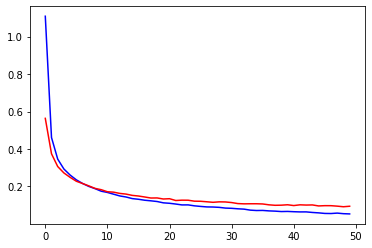

In [43]:
plt.plot(range(len(ScratchDNN.train_loss_list)), ScratchDNN.train_loss_list, color = "blue")
plt.plot(range(len(ScratchDNN.test_loss_list)), ScratchDNN.test_loss_list, color = "red")

### ＜学習率：0.001、標準偏差：0.03、活性化関数：Sigmoid＞

In [116]:
ScratchDNN_Sigmoid = ScratchDeepNeuralNetrowkClassifier(lr = 0.001, n_nodes1 = 400, n_nodes2 = 200, n_output = 10, 
                                                epoch = 50, verbose = True, sigma = 0.03, activation = "Sigmoid")
ScratchDNN_Sigmoid.fit(X_train, y_train, X_test, y_test)

Learning Start!
Epoch Count = 1, train_loss = 2.24697, test_loss = 2.18094, diff = 0.00000
Epoch Count = 2, train_loss = 2.08213, test_loss = 1.94284, diff = -0.23810
Epoch Count = 3, train_loss = 1.76254, test_loss = 1.54935, diff = -0.39349
Epoch Count = 4, train_loss = 1.37013, test_loss = 1.18654, diff = -0.36281
Epoch Count = 5, train_loss = 1.06476, test_loss = 0.93995, diff = -0.24659
Epoch Count = 6, train_loss = 0.86183, test_loss = 0.77636, diff = -0.16359
Epoch Count = 7, train_loss = 0.72234, test_loss = 0.65979, diff = -0.11657
Epoch Count = 8, train_loss = 0.62044, test_loss = 0.57366, diff = -0.08612
Epoch Count = 9, train_loss = 0.54430, test_loss = 0.50898, diff = -0.06468
Epoch Count = 10, train_loss = 0.48659, test_loss = 0.46090, diff = -0.04808
Epoch Count = 11, train_loss = 0.44171, test_loss = 0.42334, diff = -0.03756
Epoch Count = 12, train_loss = 0.40629, test_loss = 0.39480, diff = -0.02854
Epoch Count = 13, train_loss = 0.37824, test_loss = 0.37142, diff = -0

In [117]:
y_pred_Sigmoid = ScratchDNN_Sigmoid.predict(X_test)
y_pred_Sigmoid

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [118]:
import pandas as pd
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_pred_Sigmoid, output_dict=True)

# pandas.DataFrameへ変換
df_cr = pd.DataFrame(cr)
df_cr

,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.948819,0.975524,0.931707,0.920510,0.940756,0.922093,0.950207,0.948515,0.924820,0.924901,0.9395,0.938785,0.939400
recall,0.983673,0.983260,0.925388,0.928713,0.937882,0.889013,0.956159,0.931907,0.921971,0.927651,0.9395,0.938562,0.939500
f1-score,0.965932,0.979377,0.928537,0.924593,0.939317,0.905251,0.953174,0.940137,0.923393,0.926274,0.9395,0.938599,0.939379
support,980.000000,1135.000000,1032.000000,1010.000000,982.000000,892.000000,958.000000,1028.000000,974.000000,1009.000000,0.9395,10000.000000,10000.000000


#### ACC ≒ 93.9%

Text(0.5, 1.0, 'Loss Curve on Sigmoid')

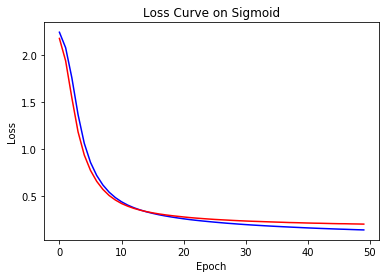

In [119]:
plt.plot(range(len(ScratchDNN_Sigmoid.train_loss_list)), ScratchDNN_Sigmoid.train_loss_list, color = "blue")
plt.plot(range(len(ScratchDNN_Sigmoid.test_loss_list)), ScratchDNN_Sigmoid.test_loss_list, color = "red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve on Sigmoid")

#### ＜学習率：0.001、標準偏差：0.03、活性化関数：ReLU＞

In [108]:
ScratchDNN_Relu = ScratchDeepNeuralNetrowkClassifier(lr = 0.001, n_nodes1 = 400, n_nodes2 = 200, n_output = 10, 
                                                epoch = 25, verbose = True, sigma = 0.03, activation = "Relu")
ScratchDNN_Relu.fit(X_train, y_train, X_test, y_test)

Learning Start!
Epoch Count = 1, train_loss = 0.30783, test_loss = 0.16165, diff = 0.00000
Epoch Count = 2, train_loss = 0.11758, test_loss = 0.13344, diff = -0.02821
Epoch Count = 3, train_loss = 0.07503, test_loss = 0.11890, diff = -0.01455
Epoch Count = 4, train_loss = 0.04973, test_loss = 0.11073, diff = -0.00817
Epoch Count = 5, train_loss = 0.03309, test_loss = 0.10768, diff = -0.00305
Epoch Count = 6, train_loss = 0.02173, test_loss = 0.10812, diff = 0.00045
Epoch Count = 7, train_loss = 0.01441, test_loss = 0.10635, diff = -0.00178
Epoch Count = 8, train_loss = 0.00962, test_loss = 0.10762, diff = 0.00127
Epoch Count = 9, train_loss = 0.00679, test_loss = 0.10884, diff = 0.00122
Epoch Count = 10, train_loss = 0.00499, test_loss = 0.10924, diff = 0.00040
Epoch Count = 11, train_loss = 0.00384, test_loss = 0.10906, diff = -0.00018
Epoch Count = 12, train_loss = 0.00299, test_loss = 0.10965, diff = 0.00059
Epoch Count = 13, train_loss = 0.00242, test_loss = 0.11004, diff = 0.00039

#### Epoc = 12　の辺りから過学習の傾向が出ている。

In [110]:
y_pred_Relu = ScratchDNN_Relu.predict(X_test)
y_pred_Relu

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [111]:
import pandas as pd
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_pred_Relu, output_dict=True)

# pandas.DataFrameへ変換
df_cr = pd.DataFrame(cr)
df_cr

,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.974900,0.983377,0.968300,0.975050,0.972892,0.964126,0.983158,0.985104,0.975207,0.970149,0.9754,0.975226,0.975428
recall,0.990816,0.990308,0.976744,0.967327,0.986762,0.964126,0.974948,0.964981,0.969199,0.966303,0.9754,0.975151,0.975400
f1-score,0.982794,0.986831,0.972504,0.971173,0.979778,0.964126,0.979036,0.974939,0.972194,0.968222,0.9754,0.975159,0.975385
support,980.000000,1135.000000,1032.000000,1010.000000,982.000000,892.000000,958.000000,1028.000000,974.000000,1009.000000,0.9754,10000.000000,10000.000000


#### ACC ≒ 97.5%

Text(0.5, 1.0, 'Loss Curve on ReLU')

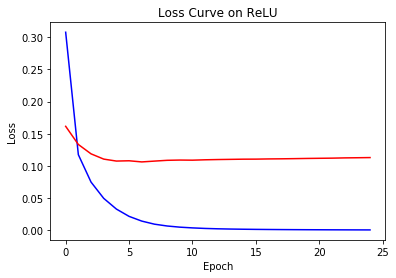

In [115]:
plt.plot(range(len(ScratchDNN_Relu.train_loss_list)), ScratchDNN_Relu.train_loss_list, color = "blue")
plt.plot(range(len(ScratchDNN_Relu.test_loss_list)), ScratchDNN_Relu.test_loss_list, color = "red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve on ReLU")

比較的きれいな学習曲線であり、Epoc = 5 でテストロスが最小となり、以降微増していくため、過学習傾向にある。

## ●Xavierの初期値で比較

#### ＜学習率：0.000005、活性化関数：Sigmoid、最適化:SGD、初期化：Xavier＞

In [258]:
ScratchDNN_Sigmoid_Xavier = ScratchDeepNeuralNetrowkClassifier(lr = 0.000005, n_nodes1 = 400, n_nodes2 = 200, n_output = 10, 
                                                epoch = 50, verbose = True, activation = "Sigmoid", Initializer = "Xavier")
ScratchDNN_Sigmoid_Xavier.fit(X_train, y_train, X_test, y_test)

★★★XavierInitializer
★★★XavierInitializer: W Set
★★★XavierInitializer: B Set
★★★XavierInitializer
★★★XavierInitializer: W Set
★★★XavierInitializer: B Set
★★★XavierInitializer
★★★XavierInitializer: W Set
★★★XavierInitializer: B Set
Learning Start!
Epoch Count = 1, train_loss = 2.41529, test_loss = 2.38071, diff = 0
Epoch Count = 2, train_loss = 2.35704, test_loss = 2.34123, diff = -0.039483728793538564
Epoch Count = 3, train_loss = 2.32937, test_loss = 2.32190, diff = -0.019327897510238223
Epoch Count = 4, train_loss = 2.31571, test_loss = 2.31211, diff = -0.009788209217309163
Epoch Count = 5, train_loss = 2.30879, test_loss = 2.30702, diff = -0.005086375658073017
Epoch Count = 6, train_loss = 2.30520, test_loss = 2.30433, diff = -0.0026964613124964565
Epoch Count = 7, train_loss = 2.30332, test_loss = 2.30287, diff = -0.0014533007467227854
Epoch Count = 8, train_loss = 2.30233, test_loss = 2.30208, diff = -0.0007950935197507114
Epoch Count = 9, train_loss = 2.30180, test_loss = 2.30164

In [259]:
y_pred_Sigmoid_Xavier = ScratchDNN_Sigmoid_Xavier.predict(X_test)
y_pred_Sigmoid_Xavier

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [260]:
import pandas as pd
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_pred_Sigmoid_Xavier, output_dict=True)

# pandas.DataFrameへ変換
df_cr = pd.DataFrame(cr)
df_cr

C:\Users\Takatoshi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.0,0.113500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1135,0.011350,0.012882
recall,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1135,0.100000,0.113500
f1-score,0.0,0.203862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1135,0.020386,0.023138
support,980.0,1135.000000,1032.0,1010.0,982.0,892.0,958.0,1028.0,974.0,1009.0,0.1135,10000.000000,10000.000000


Text(0.5, 1.0, 'Loss Curve (activation:ReLU, Initializer:Xavier)')

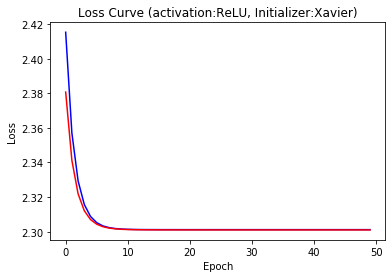

In [261]:
plt.plot(range(len(ScratchDNN_Sigmoid_Xavier.train_loss_list)), ScratchDNN_Sigmoid_Xavier.train_loss_list, color = "blue")
plt.plot(range(len(ScratchDNN_Sigmoid_Xavier.test_loss_list)), ScratchDNN_Sigmoid_Xavier.test_loss_list, color = "red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (activation:ReLU, Initializer:Xavier)")

グラフはきれいではあるが、ACC＝0.1135	であるため、精度が出ていない。

#### 学習率をもっと減らしてみる。

#### ＜学習率：0.000008、活性化関数：Sigmoid、初期化：Xavier＞

In [303]:
ScratchDNN_Sigmoid_Xavier = ScratchDeepNeuralNetrowkClassifier(lr = 0.000008, n_nodes1 = 400, n_nodes2 = 200, n_output = 10, 
                                                epoch = 50, verbose = True, activation = "Sigmoid", Initializer = "Xavier")
ScratchDNN_Sigmoid_Xavier.fit(X_train, y_train, X_test, y_test)

★★★XavierInitializer
★★★XavierInitializer: W Set
★★★XavierInitializer: B Set
★★★XavierInitializer
★★★XavierInitializer: W Set
★★★XavierInitializer: B Set
★★★XavierInitializer
★★★XavierInitializer: W Set
★★★XavierInitializer: B Set
Learning Start!
Epoch Count = 1, train_loss = 2.39628, test_loss = 2.35369, diff = 0
Epoch Count = 2, train_loss = 2.33229, test_loss = 2.31941, diff = -0.034288457491286284
Epoch Count = 3, train_loss = 2.31200, test_loss = 2.30781, diff = -0.011591864760186255
Epoch Count = 4, train_loss = 2.30508, test_loss = 2.30365, diff = -0.00416395488413368
Epoch Count = 5, train_loss = 2.30262, test_loss = 2.30209, diff = -0.0015624321801337437
Epoch Count = 6, train_loss = 2.30172, test_loss = 2.30148, diff = -0.0006096686151102482
Epoch Count = 7, train_loss = 2.30139, test_loss = 2.30123, diff = -0.00024836161189689676
Epoch Count = 8, train_loss = 2.30127, test_loss = 2.30112, diff = -0.0001065150498922307
Epoch Count = 9, train_loss = 2.30122, test_loss = 2.3010

In [304]:
y_pred_Sigmoid_Xavier = ScratchDNN_Sigmoid_Xavier.predict(X_test)
y_pred_Sigmoid_Xavier

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [305]:
import pandas as pd
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_pred_Sigmoid_Xavier, output_dict=True)

# pandas.DataFrameへ変換
df_cr = pd.DataFrame(cr)
df_cr

C:\Users\Takatoshi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.0,0.113500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1135,0.011350,0.012882
recall,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1135,0.100000,0.113500
f1-score,0.0,0.203862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1135,0.020386,0.023138
support,980.0,1135.000000,1032.0,1010.0,982.0,892.0,958.0,1028.0,974.0,1009.0,0.1135,10000.000000,10000.000000


ACC = 11％

Text(0.5, 1.0, 'Loss Curve (activation:Sigmoid, Initializer:Xavier)')

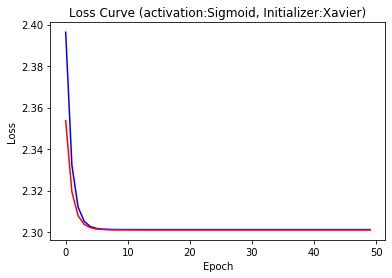

In [306]:
plt.plot(range(len(ScratchDNN_Sigmoid_Xavier.train_loss_list)), ScratchDNN_Sigmoid_Xavier.train_loss_list, color = "blue")
plt.plot(range(len(ScratchDNN_Sigmoid_Xavier.test_loss_list)), ScratchDNN_Sigmoid_Xavier.test_loss_list, color = "red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (activation:Sigmoid, Initializer:Xavier)")

Xavierの初期値を使うと、ガウスの初期値と同じ学習率では学習が進まなくなり、学習率の最適値も不明である。  
これに関しては、学習率自動最適化機能のあるAdam等を使う必要があるかと考える。

### ＜学習率：0.0005、活性化関数：Relu、初期化：Xavier＞

In [207]:
ScratchDNN_Relu_Xavier = ScratchDeepNeuralNetrowkClassifier(lr = 0.0005, n_nodes1 = 400, n_nodes2 = 200, n_output = 10, 
                                                epoch = 50, verbose = True, activation = "Relu", Initializer = "Xavier")
ScratchDNN_Relu_Xavier.fit(X_train, y_train, X_test, y_test)

★★★XavierInitializer
★★★XavierInitializer: W Set
★★★XavierInitializer: B Set
★★★XavierInitializer
★★★XavierInitializer: W Set
★★★XavierInitializer: B Set
★★★XavierInitializer
★★★XavierInitializer: W Set
★★★XavierInitializer: B Set
Learning Start!
Epoch Count = 1, train_loss = 8.75088, test_loss = 4.86324, diff = 0
Epoch Count = 2, train_loss = 4.58532, test_loss = 3.85844, diff = -1.0048069988309223
Epoch Count = 3, train_loss = 3.23146, test_loss = 2.76144, diff = -1.0969928316271598
Epoch Count = 4, train_loss = 2.58059, test_loss = 2.45788, diff = -0.3035661627420181
Epoch Count = 5, train_loss = 2.40864, test_loss = 2.37388, diff = -0.08399707446655302
Epoch Count = 6, train_loss = 2.35429, test_loss = 2.33887, diff = -0.0350119725999023
Epoch Count = 7, train_loss = 2.33037, test_loss = 2.32260, diff = -0.016269925343152192
Epoch Count = 8, train_loss = 2.31768, test_loss = 2.31301, diff = -0.009586448915977819
Epoch Count = 9, train_loss = 2.31027, test_loss = 2.30750, diff = -0.

In [208]:
y_pred_Relu_Xavier = ScratchDNN_Relu_Xavier.predict(X_test)
y_pred_Relu_Xavier

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [209]:
import pandas as pd
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_pred_Relu_Xavier, output_dict=True)

# pandas.DataFrameへ変換
df_cr = pd.DataFrame(cr)
df_cr

C:\Users\Takatoshi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.0,0.113500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1135,0.011350,0.012882
recall,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1135,0.100000,0.113500
f1-score,0.0,0.203862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1135,0.020386,0.023138
support,980.0,1135.000000,1032.0,1010.0,982.0,892.0,958.0,1028.0,974.0,1009.0,0.1135,10000.000000,10000.000000


ACC　≒　11.3％

Text(0.5, 1.0, 'Loss Curve (activation:Relu, Initializer:Xavier)')

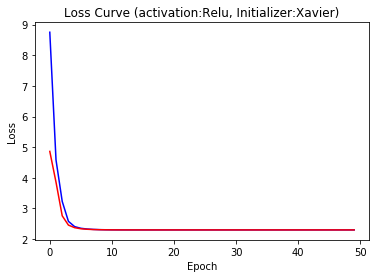

In [223]:
plt.plot(range(len(ScratchDNN_Relu_Xavier.train_loss_list)), ScratchDNN_Relu_Xavier.train_loss_list, color = "blue")
plt.plot(range(len(ScratchDNN_Relu_Xavier.test_loss_list)), ScratchDNN_Relu_Xavier.test_loss_list, color = "red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (activation:Relu, Initializer:Xavier)")

学習曲線は、きれいな曲線となっているが、ACCが低い

#### ＜学習率：0.00001、活性化関数：Tanh、初期化：Xavier＞

In [219]:
ScratchDNN_Tanh_Xavier = ScratchDeepNeuralNetrowkClassifier(lr = 0.00001, n_nodes1 = 400, n_nodes2 = 200, n_output = 10, 
                                                epoch = 50, verbose = True, activation = "Tanh", Initializer = "Xavier")
ScratchDNN_Tanh_Xavier.fit(X_train, y_train, X_test, y_test)

★★★XavierInitializer
★★★XavierInitializer: W Set
★★★XavierInitializer: B Set
★★★XavierInitializer
★★★XavierInitializer: W Set
★★★XavierInitializer: B Set
★★★XavierInitializer
★★★XavierInitializer: W Set
★★★XavierInitializer: B Set
Learning Start!
Epoch Count = 1, train_loss = 2.38618, test_loss = 2.34125, diff = 0
Epoch Count = 2, train_loss = 2.32257, test_loss = 2.31214, diff = -0.02911586225978402
Epoch Count = 3, train_loss = 2.30703, test_loss = 2.30435, diff = -0.007789357285325149
Epoch Count = 4, train_loss = 2.30286, test_loss = 2.30209, diff = -0.002254405185354802
Epoch Count = 5, train_loss = 2.30169, test_loss = 2.30140, diff = -0.0006948418528067712
Epoch Count = 6, train_loss = 2.30135, test_loss = 2.30117, diff = -0.00022958761721225684
Epoch Count = 7, train_loss = 2.30125, test_loss = 2.30109, diff = -8.267286952490238e-05
Epoch Count = 8, train_loss = 2.30122, test_loss = 2.30105, diff = -3.286439639005323e-05
Epoch Count = 9, train_loss = 2.30121, test_loss = 2.3010

In [220]:
y_pred_Tanh_Xavier = ScratchDNN_Tanh_Xavier.predict(X_test)
y_pred_Tanh_Xavier

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [221]:
import pandas as pd
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_pred_Tanh_Xavier, output_dict=True)

# pandas.DataFrameへ変換
df_cr = pd.DataFrame(cr)
df_cr

C:\Users\Takatoshi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.0,0.113500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1135,0.011350,0.012882
recall,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1135,0.100000,0.113500
f1-score,0.0,0.203862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1135,0.020386,0.023138
support,980.0,1135.000000,1032.0,1010.0,982.0,892.0,958.0,1028.0,974.0,1009.0,0.1135,10000.000000,10000.000000


ACC ≒ 11.4％

Text(0.5, 1.0, 'Loss Curve (activation:Sigmoid, Initializer:Xavier)')

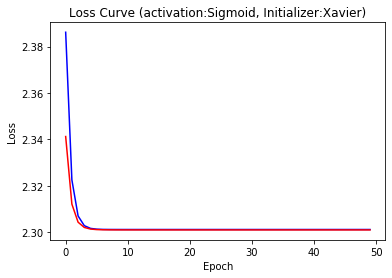

In [222]:
plt.plot(range(len(ScratchDNN_Tanh_Xavier.train_loss_list)), ScratchDNN_Tanh_Xavier.train_loss_list, color = "blue")
plt.plot(range(len(ScratchDNN_Tanh_Xavier.test_loss_list)), ScratchDNN_Tanh_Xavier.test_loss_list, color = "red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (activation:Sigmoid, Initializer:Xavier)")

学習曲線はきれいであるが、こちらもACC ≒ 11.4%であるため全然ダメ。  
やはり学習率の動的変更が必要であろう。

### ＜学習率：0.000001、活性化関数：Sigmoid、初期化：He＞

In [307]:
ScratchDNN_Sigmoid_He = ScratchDeepNeuralNetrowkClassifier(lr = 0.000001, n_nodes1 = 400, n_nodes2 = 200, n_output = 10, 
                                                epoch = 50, verbose = True, activation = "Sigmoid", Initializer = "He")
ScratchDNN_Sigmoid_He.fit(X_train, y_train, X_test, y_test)

Learning Start!
Epoch Count = 1, train_loss = 2.43450, test_loss = 2.42783, diff = 0
Epoch Count = 2, train_loss = 2.41668, test_loss = 2.41118, diff = -0.016647830491002935
Epoch Count = 3, train_loss = 2.40138, test_loss = 2.39686, diff = -0.014323028278258487
Epoch Count = 4, train_loss = 2.38822, test_loss = 2.38452, diff = -0.01234470876211713
Epoch Count = 5, train_loss = 2.37688, test_loss = 2.37386, diff = -0.010657859720766272
Epoch Count = 6, train_loss = 2.36709, test_loss = 2.36464, diff = -0.009216724587809644
Epoch Count = 7, train_loss = 2.35864, test_loss = 2.35666, diff = -0.007983152212215572
Epoch Count = 8, train_loss = 2.35132, test_loss = 2.34973, diff = -0.006925265099936073
Epoch Count = 9, train_loss = 2.34497, test_loss = 2.34372, diff = -0.00601637575097147
Epoch Count = 10, train_loss = 2.33946, test_loss = 2.33848, diff = -0.005234099793140157
Epoch Count = 11, train_loss = 2.33467, test_loss = 2.33392, diff = -0.00455962729648185
Epoch Count = 12, train_lo

In [308]:
y_pred_Sigmoid_He = ScratchDNN_Sigmoid_He.predict(X_test)
y_pred_Sigmoid_He

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [309]:
import pandas as pd
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_pred_Sigmoid_He, output_dict=True)

# pandas.DataFrameへ変換
df_cr = pd.DataFrame(cr)
df_cr

C:\Users\Takatoshi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.0,0.113500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1135,0.011350,0.012882
recall,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1135,0.100000,0.113500
f1-score,0.0,0.203862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1135,0.020386,0.023138
support,980.0,1135.000000,1032.0,1010.0,982.0,892.0,958.0,1028.0,974.0,1009.0,0.1135,10000.000000,10000.000000


Text(0.5, 1.0, 'Loss Curve (activation:Sigmoid, Initializer:He)')

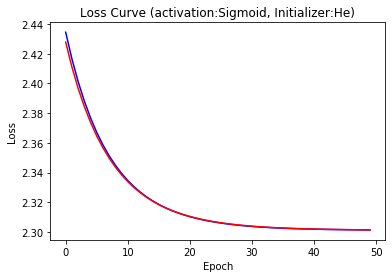

In [310]:
plt.plot(range(len(ScratchDNN_Sigmoid_He.train_loss_list)), ScratchDNN_Sigmoid_He.train_loss_list, color = "blue")
plt.plot(range(len(ScratchDNN_Sigmoid_He.test_loss_list)), ScratchDNN_Sigmoid_He.test_loss_list, color = "red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (activation:Sigmoid, Initializer:He)")

### ＜学習率：0.000001、活性化関数：Tanh、初期化：He＞

In [311]:
ScratchDNN_Tanh_He = ScratchDeepNeuralNetrowkClassifier(lr = 0.000001, n_nodes1 = 400, n_nodes2 = 200, n_output = 10, 
                                                epoch = 50, verbose = True, activation = "Tanh", Initializer = "He")
ScratchDNN_Tanh_He.fit(X_train, y_train, X_test, y_test)

Learning Start!
Epoch Count = 1, train_loss = 2.43450, test_loss = 2.42783, diff = 0
Epoch Count = 2, train_loss = 2.41668, test_loss = 2.41118, diff = -0.016647862678621284
Epoch Count = 3, train_loss = 2.40138, test_loss = 2.39686, diff = -0.01432305143592405
Epoch Count = 4, train_loss = 2.38822, test_loss = 2.38452, diff = -0.012344724881251157
Epoch Count = 5, train_loss = 2.37688, test_loss = 2.37386, diff = -0.010657870376571843
Epoch Count = 6, train_loss = 2.36709, test_loss = 2.36464, diff = -0.009216731026648883
Epoch Count = 7, train_loss = 2.35864, test_loss = 2.35666, diff = -0.00798315541987149
Epoch Count = 8, train_loss = 2.35132, test_loss = 2.34973, diff = -0.006925265855333151
Epoch Count = 9, train_loss = 2.34497, test_loss = 2.34372, diff = -0.006016374668682989
Epoch Count = 10, train_loss = 2.33946, test_loss = 2.33848, diff = -0.005234097357070144
Epoch Count = 11, train_loss = 2.33467, test_loss = 2.33392, diff = -0.004559623886672526
Epoch Count = 12, train_l

In [312]:
y_pred_Tanh_He = ScratchDNN_Tanh_He.predict(X_test)
y_pred_Tanh_He

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [313]:
import pandas as pd
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_pred_Tanh_He, output_dict=True)

# pandas.DataFrameへ変換
df_cr = pd.DataFrame(cr)
df_cr

C:\Users\Takatoshi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.0,0.113500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1135,0.011350,0.012882
recall,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1135,0.100000,0.113500
f1-score,0.0,0.203862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1135,0.020386,0.023138
support,980.0,1135.000000,1032.0,1010.0,982.0,892.0,958.0,1028.0,974.0,1009.0,0.1135,10000.000000,10000.000000


Text(0.5, 1.0, 'Loss Curve (activation:Tanh, Initializer:He)')

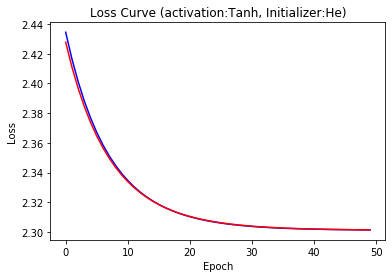

In [314]:
plt.plot(range(len(ScratchDNN_Tanh_He.train_loss_list)), ScratchDNN_Tanh_He.train_loss_list, color = "blue")
plt.plot(range(len(ScratchDNN_Tanh_He.test_loss_list)), ScratchDNN_Tanh_He.test_loss_list, color = "red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (activation:Tanh, Initializer:He)")

### ●Heの初期値で比較

#### ＜学習率：0.000001、活性化関数：Relu、初期化：He＞

In [315]:
ScratchDNN_Relu_He = ScratchDeepNeuralNetrowkClassifier(lr = 0.000001, n_nodes1 = 400, n_nodes2 = 200, n_output = 10, 
                                                epoch = 50, verbose = True, activation = "Relu", Initializer = "He")
ScratchDNN_Relu_He.fit(X_train, y_train, X_test, y_test)

Learning Start!
Epoch Count = 1, train_loss = 14.52931, test_loss = 14.53530, diff = 0
Epoch Count = 2, train_loss = 14.44636, test_loss = 14.53530, diff = -0.0
Epoch Count = 3, train_loss = 14.32184, test_loss = 14.53530, diff = -0.0
Epoch Count = 4, train_loss = 13.81983, test_loss = 12.83405, diff = -1.7012479860279512
Epoch Count = 5, train_loss = 12.34102, test_loss = 13.11021, diff = 0.2761613603972233
Epoch Count = 6, train_loss = 10.51025, test_loss = 11.56306, diff = -1.5471517505464085
Epoch Count = 7, train_loss = 8.83251, test_loss = 8.33013, diff = -3.2329301051023194
Epoch Count = 8, train_loss = 7.50281, test_loss = 8.82639, diff = 0.49626436685595365
Epoch Count = 9, train_loss = 6.43014, test_loss = 7.28005, diff = -1.546348490253779
Epoch Count = 10, train_loss = 5.69444, test_loss = 5.47606, diff = -1.8039833087700714
Epoch Count = 11, train_loss = 5.17947, test_loss = 6.65311, diff = 1.1770424489670832
Epoch Count = 12, train_loss = 4.77291, test_loss = 3.82485, dif

In [316]:
y_pred_Relu_He = ScratchDNN_Relu_He.predict(X_test)
y_pred_Relu_He

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [317]:
import pandas as pd
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_pred_Relu_He, output_dict=True)

# pandas.DataFrameへ変換
df_cr = pd.DataFrame(cr)
df_cr

,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.876700,0.928512,0.925498,0.907143,0.597637,0.873153,0.951991,0.942105,0.880713,0.918750,0.8611,0.880220,0.881541
recall,0.986735,0.984141,0.854651,0.880198,0.978615,0.794843,0.848643,0.870623,0.811088,0.582755,0.8611,0.859229,0.861100
f1-score,0.928469,0.955518,0.888665,0.893467,0.742085,0.832160,0.897351,0.904954,0.844468,0.713159,0.8611,0.860030,0.861698
support,980.000000,1135.000000,1032.000000,1010.000000,982.000000,892.000000,958.000000,1028.000000,974.000000,1009.000000,0.8611,10000.000000,10000.000000


ACC = 86%

Text(0.5, 1.0, 'Loss Curve (activation:Relu, Initializer:He)')

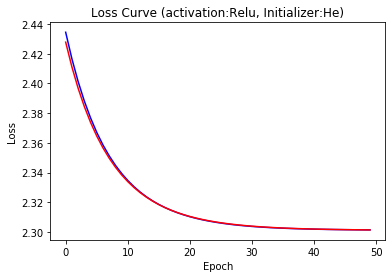

In [318]:
plt.plot(range(len(ScratchDNN_Tanh_He.train_loss_list)), ScratchDNN_Tanh_He.train_loss_list, color = "blue")
plt.plot(range(len(ScratchDNN_Tanh_He.test_loss_list)), ScratchDNN_Tanh_He.test_loss_list, color = "red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (activation:Relu, Initializer:He)")

### ●最適化として、Adagradを用いて比較

#### ＜学習率：0.001、活性化関数：Sigmoid、初期化：He、optimizer：Adagrad＞

In [330]:
ScratchDNN_Sigmoid_He_AdaGrad = ScratchDeepNeuralNetrowkClassifier(lr = 0.001, n_nodes1 = 400, n_nodes2 = 200, n_output = 10, 
                                                epoch = 50, verbose = True, activation = "Sigmoid", Initializer = "He",  optimizer = "AdaGrad")
ScratchDNN_Sigmoid_He_AdaGrad.fit(X_train, y_train, X_test, y_test)

Learning Start!
self.h is None
self.h is None
self.h is None
Epoch Count = 1, train_loss = 2.30277, test_loss = 2.30152, diff = 0
Epoch Count = 2, train_loss = 2.30177, test_loss = 2.30134, diff = -0.00017757674072482743
Epoch Count = 3, train_loss = 2.30165, test_loss = 2.30127, diff = -7.85310033566411e-05
Epoch Count = 4, train_loss = 2.30158, test_loss = 2.30122, diff = -4.456987110001975e-05
Epoch Count = 5, train_loss = 2.30154, test_loss = 2.30119, diff = -2.8967953522585077e-05
Epoch Count = 6, train_loss = 2.30151, test_loss = 2.30117, diff = -2.0509470630702964e-05
Epoch Count = 7, train_loss = 2.30149, test_loss = 2.30116, diff = -1.539569326958201e-05
Epoch Count = 8, train_loss = 2.30147, test_loss = 2.30114, diff = -1.2055373368902167e-05
Epoch Count = 9, train_loss = 2.30146, test_loss = 2.30113, diff = -9.744005219136653e-06
Epoch Count = 10, train_loss = 2.30144, test_loss = 2.30113, diff = -8.071877370952052e-06
Epoch Count = 11, train_loss = 2.30143, test_loss = 2.30

In [331]:
y_pred_Sigmoid_He_AdaGrad = ScratchDNN_Relu_He_AdaGrad.predict(X_test)
y_pred_Sigmoid_He_AdaGrad

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [332]:
import pandas as pd
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_pred_Sigmoid_He_AdaGrad, output_dict=True)

# pandas.DataFrameへ変換
df_cr = pd.DataFrame(cr)
df_cr

,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.974253,0.974561,0.902830,0.889756,0.749413,0.853871,0.957356,0.921359,0.880170,0.969957,0.9021,0.907353,0.908912
recall,0.965306,0.978855,0.927326,0.902970,0.974542,0.877803,0.937370,0.923152,0.852156,0.671952,0.9021,0.901143,0.902100
f1-score,0.969759,0.976703,0.914914,0.896314,0.847278,0.865672,0.947257,0.922255,0.865936,0.793911,0.9021,0.900000,0.901263
support,980.000000,1135.000000,1032.000000,1010.000000,982.000000,892.000000,958.000000,1028.000000,974.000000,1009.000000,0.9021,10000.000000,10000.000000


ACC = 90%

Text(0.5, 1.0, 'Loss Curve (activation:Relu, Initializer:He)')

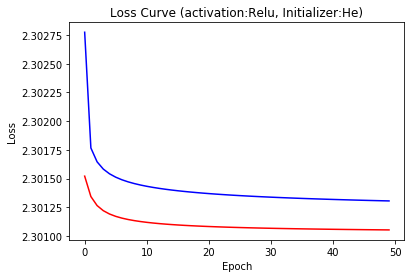

In [333]:
plt.plot(range(len(ScratchDNN_Sigmoid_He_AdaGrad.train_loss_list)), ScratchDNN_Sigmoid_He_AdaGrad.train_loss_list, color = "blue")
plt.plot(range(len(ScratchDNN_Sigmoid_He_AdaGrad.test_loss_list)), ScratchDNN_Sigmoid_He_AdaGrad.test_loss_list, color = "red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (activation:Relu, Initializer:He)")

#### ＜学習率：0.001、活性化関数：Relu、初期化：He、optimizer：Adagrad＞

In [326]:
ScratchDNN_Relu_He_AdaGrad = ScratchDeepNeuralNetrowkClassifier(lr = 0.001, n_nodes1 = 400, n_nodes2 = 200, n_output = 10, 
                                                epoch = 50, verbose = True, activation = "Relu", Initializer = "He",  optimizer = "AdaGrad")
ScratchDNN_Relu_He_AdaGrad.fit(X_train, y_train, X_test, y_test)

Learning Start!
self.h is None
self.h is None
self.h is None
Epoch Count = 1, train_loss = 3.84156, test_loss = 1.68554, diff = 0
Epoch Count = 2, train_loss = 1.78709, test_loss = 1.73663, diff = 0.05108648125984194
Epoch Count = 3, train_loss = 1.51122, test_loss = 1.41754, diff = -0.3190902298443803
Epoch Count = 4, train_loss = 1.39063, test_loss = 1.41091, diff = -0.006626809245393606
Epoch Count = 5, train_loss = 1.28859, test_loss = 1.29960, diff = -0.11131467883729207
Epoch Count = 6, train_loss = 1.19144, test_loss = 1.06637, diff = -0.23322396175295013
Epoch Count = 7, train_loss = 1.13842, test_loss = 1.14876, diff = 0.0823883065379345
Epoch Count = 8, train_loss = 1.09717, test_loss = 1.03431, diff = -0.11445492758801623
Epoch Count = 9, train_loss = 1.05518, test_loss = 0.89861, diff = -0.1356993015886846
Epoch Count = 10, train_loss = 1.02960, test_loss = 0.88495, diff = -0.013657683104049134
Epoch Count = 11, train_loss = 1.00341, test_loss = 0.83228, diff = -0.052673273

In [327]:
y_pred_Relu_He_AdaGrad = ScratchDNN_Relu_He_AdaGrad.predict(X_test)
y_pred_Relu_He_AdaGrad

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [328]:
import pandas as pd
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_pred_Relu_He_AdaGrad, output_dict=True)

# pandas.DataFrameへ変換
df_cr = pd.DataFrame(cr)
df_cr

,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.974253,0.974561,0.902830,0.889756,0.749413,0.853871,0.957356,0.921359,0.880170,0.969957,0.9021,0.907353,0.908912
recall,0.965306,0.978855,0.927326,0.902970,0.974542,0.877803,0.937370,0.923152,0.852156,0.671952,0.9021,0.901143,0.902100
f1-score,0.969759,0.976703,0.914914,0.896314,0.847278,0.865672,0.947257,0.922255,0.865936,0.793911,0.9021,0.900000,0.901263
support,980.000000,1135.000000,1032.000000,1010.000000,982.000000,892.000000,958.000000,1028.000000,974.000000,1009.000000,0.9021,10000.000000,10000.000000


ACC = 90%

Text(0.5, 1.0, 'Loss Curve (activation:Relu, Initializer:He)')

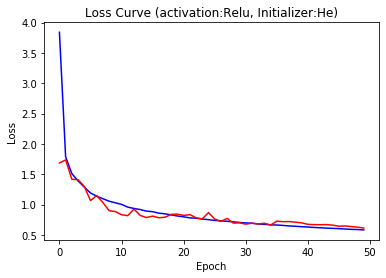

In [329]:
plt.plot(range(len(ScratchDNN_Relu_He_AdaGrad.train_loss_list)), ScratchDNN_Relu_He_AdaGrad.train_loss_list, color = "blue")
plt.plot(range(len(ScratchDNN_Relu_He_AdaGrad.test_loss_list)), ScratchDNN_Relu_He_AdaGrad.test_loss_list, color = "red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (activation:Relu, Initializer:He)")

#### ＜学習率：0.0001、活性化関数：Tanh、初期化：He、optimizer：Adagrad＞

In [276]:
ScratchDNN_Tanh_He_AdaGrad = ScratchDeepNeuralNetrowkClassifier(lr = 0.001, n_nodes1 = 400, n_nodes2 = 200, n_output = 10, 
                                                epoch = 50, verbose = True, activation = "Tanh", Initializer = "He",  optimizer = "AdaGrad")
ScratchDNN_Tanh_He_AdaGrad.fit(X_train, y_train, X_test, y_test)

Learning Start!
self.h is None
self.h is None
self.h is None
Epoch Count = 1, train_loss = 2.40488, test_loss = 2.38969, diff = 0
Epoch Count = 2, train_loss = 2.37810, test_loss = 2.37216, diff = -0.017536642053512352
Epoch Count = 3, train_loss = 2.36438, test_loss = 2.36092, diff = -0.011237783517871414
Epoch Count = 4, train_loss = 2.35498, test_loss = 2.35274, diff = -0.008173308025243742
Epoch Count = 5, train_loss = 2.34793, test_loss = 2.34642, diff = -0.0063268013190267425
Epoch Count = 6, train_loss = 2.34237, test_loss = 2.34133, diff = -0.0050877116431573555
Epoch Count = 7, train_loss = 2.33784, test_loss = 2.33713, diff = -0.004199392554241843
Epoch Count = 8, train_loss = 2.33407, test_loss = 2.33360, diff = -0.003533163696952446
Epoch Count = 9, train_loss = 2.33088, test_loss = 2.33058, diff = -0.003016791202584912
Epoch Count = 10, train_loss = 2.32814, test_loss = 2.32797, diff = -0.0026063809028404883
Epoch Count = 11, train_loss = 2.32577, test_loss = 2.32570, diff

In [277]:
y_pred_Tanh_He_AdaGrad = ScratchDNN_Tanh_He_AdaGrad.predict(X_test)
y_pred_Tanh_He_AdaGrad

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [278]:
import pandas as pd
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_pred_Tanh_He_AdaGrad, output_dict=True)

# pandas.DataFrameへ変換
df_cr = pd.DataFrame(cr)
df_cr

C:\Users\Takatoshi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.0,0.113500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1135,0.011350,0.012882
recall,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1135,0.100000,0.113500
f1-score,0.0,0.203862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1135,0.020386,0.023138
support,980.0,1135.000000,1032.0,1010.0,982.0,892.0,958.0,1028.0,974.0,1009.0,0.1135,10000.000000,10000.000000


#### ACC:11%

Text(0.5, 1.0, 'Loss Curve (activation:Tanh, Initializer:He)')

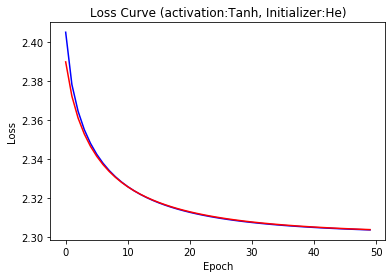

In [279]:
plt.plot(range(len(ScratchDNN_Tanh_He_AdaGrad.train_loss_list)), ScratchDNN_Tanh_He_AdaGrad.train_loss_list, color = "blue")
plt.plot(range(len(ScratchDNN_Tanh_He_AdaGrad.test_loss_list)), ScratchDNN_Tanh_He_AdaGrad.test_loss_list, color = "red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (activation:Tanh, Initializer:He)")

### ●最適化として、Adamを用いて比較

#### ＜学習率：0.001、活性化関数：Relu、初期化：He、optimizer：Adam＞

In [339]:
ScratchDNN_Sigmoid_He_Adam = ScratchDeepNeuralNetrowkClassifier(lr = 0.0001, n_nodes1 = 400, n_nodes2 = 200, n_output = 10, 
                                                epoch = 50, verbose = True, activation = "Relu", Initializer = "He",  optimizer = "Adam")
ScratchDNN_Sigmoid_He_Adam.fit(X_train, y_train, X_test, y_test)

Learning Start!
self.h initial
self.h initial
self.h initial
Epoch Count = 1, train_loss = 4.43472, test_loss = 2.90461, diff = 0
Epoch Count = 2, train_loss = 2.04368, test_loss = 2.29770, diff = -0.6069019380530554
Epoch Count = 3, train_loss = 1.06113, test_loss = 0.67179, diff = -1.625916813625139
Epoch Count = 4, train_loss = 0.31220, test_loss = 0.20467, diff = -0.4671183509578156
Epoch Count = 5, train_loss = 0.15831, test_loss = 0.13715, diff = -0.06751724167021503
Epoch Count = 6, train_loss = 0.10734, test_loss = 0.12971, diff = -0.0074462639894326
Epoch Count = 7, train_loss = 0.08747, test_loss = 0.14227, diff = 0.012564418875875422
Epoch Count = 8, train_loss = 0.07143, test_loss = 0.13668, diff = -0.005591780699583965
Epoch Count = 9, train_loss = 0.05626, test_loss = 0.16931, diff = 0.032627110252597596
Epoch Count = 10, train_loss = 0.04960, test_loss = 0.21306, diff = 0.043753824935932495
Epoch Count = 11, train_loss = 0.04756, test_loss = 0.14021, diff = -0.0728538375

In [340]:
y_pred_Relu_He_Adam = ScratchDNN_Sigmoid_He_Adam.predict(X_test)
y_pred_Relu_He_Adam

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [341]:
import pandas as pd
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_pred_Relu_He_Adam, output_dict=True)

# pandas.DataFrameへ変換
df_cr = pd.DataFrame(cr)
df_cr

,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.980866,0.993783,0.980695,0.972387,0.988518,0.974157,0.978216,0.977451,0.976362,0.959064,0.9783,0.978150,0.978368
recall,0.993878,0.985903,0.984496,0.976238,0.964358,0.971973,0.984342,0.969844,0.975359,0.975223,0.9783,0.978162,0.978300
f1-score,0.987329,0.989828,0.982592,0.974308,0.976289,0.973064,0.981270,0.973633,0.975860,0.967076,0.9783,0.978125,0.978303
support,980.000000,1135.000000,1032.000000,1010.000000,982.000000,892.000000,958.000000,1028.000000,974.000000,1009.000000,0.9783,10000.000000,10000.000000


ACC ≒98％

Text(0.5, 1.0, 'Loss Curve (activation:Sigmoid, Initializer:He, Optimaizer:Adam)')

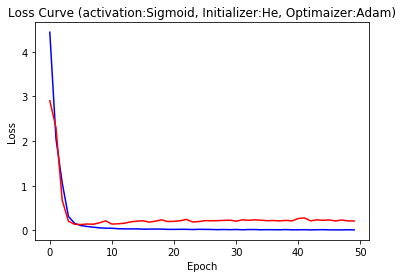

In [342]:
plt.plot(range(len(ScratchDNN_Sigmoid_He_Adam.train_loss_list)), ScratchDNN_Sigmoid_He_Adam.train_loss_list, color = "blue")
plt.plot(range(len(ScratchDNN_Sigmoid_He_Adam.test_loss_list)), ScratchDNN_Sigmoid_He_Adam.test_loss_list, color = "red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (activation:Sigmoid, Initializer:He, Optimaizer:Adam)")

#### 最適化手法にAdamを用いた場合（活性化関数：Relu）、Epoch = 5 ぐらいでlossが最小となっている。  
#### その後test_lossはガタガタと安定しないが、過学習傾向が出ているのかもしれない。最適化手法を用いた場合、lossの最小値に向けて学習率を変動させ、加速度を付けて勾配を下っていく。
#### lossの大域最小値付近でも同様に学習率を微調整をしているが、学習率は０にはならないので、目的地付近でフラフラと終着地点を模索している感じである。

## 【総評】

①初期化手法：標準偏差、勾配降下：SGDを用い、活性化関数を変更していった場合、精度としては、Relu＞Tanh＞Sigmoidという結果になった。  
やはりReluが最強といった感じ。

②初期化手法をXavierやHeに変更してみて学習実行をしてみたが、想像に反して精度が上がらなかった。  
おそらく初期化手法を変えたため、最適な学習率が変わり、その値を見いだせなかったのが原因と考えられる。

③ ①②に加えて最適化手法をAdaGradやAdamに変更して学習を実施してみた。AdaGradでは、もう少し急激なロスの減少を期待したが、そこまでロスは下がらなかった。  
活性化関数Reluと最適化手法にAdamを用いた際に最高のACC≒98％となっており、ロス曲線が急激に減少しているのが分かる。

最適化手法として、Adamの次にRAdamなるアルゴリズムも出てきているようなので、こちらも今後チャレンジしていきたい。